In [32]:
#this notebook aims to understand the LSS contribution
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fitsio
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18');
from colossus.lss import mass_function
plt.rcParams['figure.dpi'] = 200

In [4]:
# getting the data
dat = fitsio.FITS('DataStore/bigMDPL/download')[1]
idx = dat.where("mvir>10**12 && mvir<10**16")
dat = dat[idx]
#dat = dat.read()

lbox = 2500
dat['x'] = dat['x']%lbox
dat['y'] = dat['y']%lbox
dat['z'] = dat['z']%lbox
print(len(dat['x'])/(lbox)**3)

0.00387864704


In [5]:
print(len(dat['x'])/(250)**3)

3.87864704


In [6]:
#assigning jackknife region
ljacks = 125
jlen = lbox/ljacks
ix = dat['x']//jlen; iy = dat['y']//jlen; iz = dat['z']//jlen

xjkreg = ix + iy*ljacks + iz*ljacks**2

uqjkregs, counts = np.unique(xjkreg, return_counts=1)
uqjkregs = uqjkregs[counts>0]
counts   = counts[counts>0]
#overdensity calculation
delta = (counts/(sum(counts)/ljacks**3)) -1

In [36]:
def get_hmf(mharr, lbox):
    bins = np.linspace(12,16,31) # log Mvir bins
    ibins = (np.log10(mharr) - 12)//(bins[1]-bins[0])
    uqibins, counts = np.unique(ibins,return_counts=1)
    # full hmf
    xx = 12 + uqibins*(bins[1] - bins[0]) + (bins[1] - bins[0])*0.5 
    return xx, counts*1/(bins[1]-bins[0])*1/(lbox)**3 

Text(0, 0.5, '$n(M_{\\rm h})$')

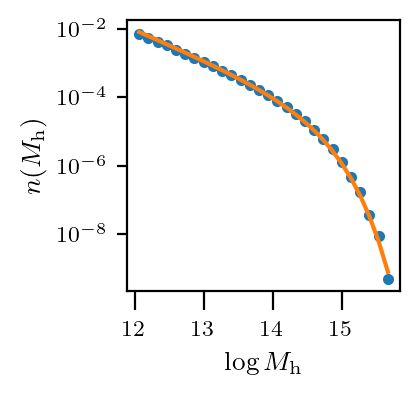

In [37]:
xx, hmf = get_hmf(dat['mvir'], lbox)
plt.subplot(3,3,1)
plt.plot(xx, hmf, '.')
mfunc = mass_function.massFunction(10**xx, 0.0, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')
plt.plot(xx, mfunc/np.log10(np.e))
plt.yscale('log')
plt.xlabel(r'$\log M_{\rm h}$')
plt.ylabel(r'$n(M_{\rm h})$')

(-1.5, 2.5)

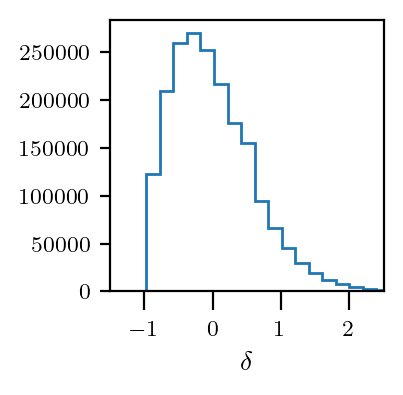

In [34]:
plt.subplot(3,3,1)
plt.hist(delta, histtype='step', bins=30);
plt.xlabel('$\delta$')
plt.xlim(-1.5,2.5)

In [26]:
print(np.percentile(delta,75))
print(np.percentile(delta,25))

0.35356477293690536
-0.4521285442874431


Text(0, 0.5, '$n(M_{\\rm h})$')

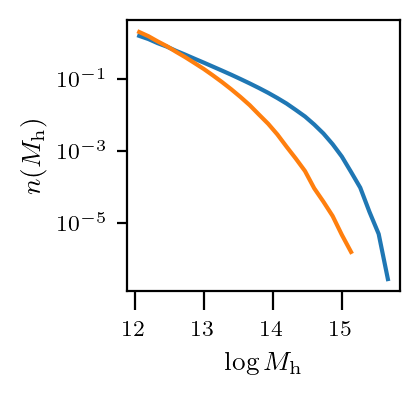

In [40]:
plt.subplot(3,3,1)
# top 25 percentile
idx = delta>np.percentile(delta,75)
yy = dat['mvir'][np.isin(xjkreg, uqjkregs[idx])]
xx, hmf = get_hmf(yy, lbox)
hmf = hmf/(sum(hmf)*(xx[1]-xx[0]))
plt.plot(xx, hmf, '-')
# bottom 25 percentile
idx = delta<np.percentile(delta,25)
yy = dat['mvir'][np.isin(xjkreg, uqjkregs[idx])]
xx, hmf = get_hmf(yy, lbox)
hmf = hmf/(sum(hmf)*(xx[1]-xx[0]))
plt.plot(xx, hmf, '-')

plt.yscale('log')

plt.xlabel(r'$\log M_{\rm h}$')
plt.ylabel(r'$n(M_{\rm h})$')


In [23]:
print(sum(yhist))

0.2968171274860315


In [16]:
# from colossus.lss import mass_function

# z = [0.0]#, 1.0, 2.0, 4.0]
# M = 10**np.arange(11.0, 15.5, 0.1)

# plt.subplot(2,2,1)
# plt.xlabel('M200m')
# plt.ylabel('dn/dln(M)')
# plt.loglog()
# plt.xlim(1E11, 4E15)
# plt.ylim(1E-7, 1E-1)
# for i in range(len(z)):
#     mfunc = mass_function.massFunction(M, z[i], mdef = '200m', model = 'tinker08', q_out = 'dndlnM')
#     plt.plot(M, mfunc, '-', label = 'z = %.1f' % (z[i]))
# plt.legend();

In [ ]:
# #assigning jackknife region
# ljacks = 100
# jlen = 2500/ljacks
# ix = dat['x']//jlen; iy = dat['y']//jlen; iz = dat['z']//jlen

# xjkreg = ix + iy*ljacks + iz*ljacks**2

# njacks = len(np.unique(xjkreg))
# print('njacks=%d'%njacks)

# nhalo = len(ix)/(2500)**3
# rbins = np.logspace(np.log(4), np.log(20), 11)
# rad   = 0.5*(rbins[:-1] + rbins[1:])

# RR = 4*np.pi*(0.5*(rbins[:-1] + rbins[1:]))**2 * (rbins[1:] - rbins[:-1]) * nhalo


# from scipy.spatial import cKDTree
# xi = np.zeros(len(rad)*njacks)

# # intrbins, x0 = jj*len(ra), x1 = (jj+1)* len(ra)
# # tree on full halo catalog
# htree = cKDTree(np.transpose([dat['x'], dat['y'], dat['z']]), boxsize=2500)
# for jj in range(njacks):
#     idx  = (xjkreg!=jj)

#     jtree = cKDTree(np.transpose([dat['x'][idx], dat['y'][idx], dat['z'][idx]]), boxsize=2500)
#     DD = htree.count_neighbors(jtree, rbins, cumulative=True)
#     DD = np.diff(DD)/sum(idx)
#     x0 = jj*len(DD); x1 = (jj+1)* len(DD)
    
#     xi[x0:x1] = DD/RR - 1
#     print(jj)
    

In [ ]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')
ximm = cosmo.correlationFunction(rad,0.0)
bias = np.sqrt(xi/np.tile(ximm, njacks))
#saving the bias for logMh 11 threshold
bias11 = bias.reshape((njacks, len(rad)))

yy = np.mean(bias11, axis=0)

cov     = np.zeros((len(rad),len(rad)))
for ii in range(len(rad)):
    for jj in range(len(rad)):
        cov[ii][jj] = np.mean((bias11[ii,:] - yy[ii])*(bias11[jj,:] - yy[jj]))
        cov[ii][jj] = (njacks - 1)*cov[ii][jj]



yyerr = np.sqrt(np.diag(cov))

plt.subplot(2,2,1)
plt.errorbar(rad, yy, yerr=yyerr, fmt='.', capsize=3)
plt.xlim(5.5,20)
plt.xlabel(r'$r \, [{\rm h^{-1}Mpc}]$')
plt.ylabel(r'$b_{h}$')
plt.xscale('log')    
plt.title(r'$\log[M_{\rm vir}/({\rm h^{-1}M_{\odot}})] > 11$')


In [ ]:
corr = 0.0*cov
for ii in range(len(rad)):
    for jj in range(len(rad)):
        corr[ii][jj] = cov[ii][jj]*1.0/(yyerr[ii]*yyerr[jj])


plt.subplot(2,2,1)
plt.imshow(corr,cmap='PuOr_r',vmin=-1,vmax=1,origin='lower',aspect='equal')
plt.colorbar()

Text(0, 0.5, '$\\xi(r)$')

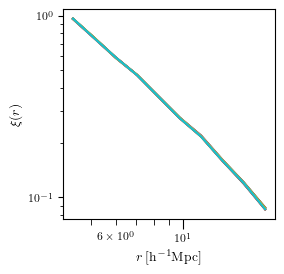

In [7]:
plt.subplot(2,2,1)
for jjx in np.random.randint(njacks, size=10):
    x0 = jjx*len(rad); x1 = (jjx+1)* len(rad)
    plt.plot(rad,xi[x0:x1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r \, [{\rm h^{-1}Mpc}]$')
plt.ylabel(r'$\xi(r)$')
